In [20]:
#copy from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook (코드 원본 경로)

* imports

In [2]:
# !pip install imgaug

In [ ]:
import os

import warnings

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
np.bool = bool
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.layers import Input
from keras.optimizers import *
from keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from keras.callbacks import *

from tensorflow.keras.applications import ResNet50
from keras.applications.densenet import DenseNet121, preprocess_input


* how many breeds and pictures we have

In [ ]:
breed_list = os.listdir(r"C:\project\100.Project\11.1차프로젝트\01.견종판별\archive\images\Images")
num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(r"C:\project\100.Project\11.1차프로젝트\01.견종판별\archive\images\Images\{}".format(breed)))
print("{} images".format(n_total_images))

121 breeds
20690 images


* label strings and numbers mapping

In [ ]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i: v})

In [4]:
len(label_maps_rev)

121

In [ ]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir =r"C:\project\100.Project\11.1차프로젝트\01.견종판별\archive\images\Images\{}".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + '\\' + images[i])
        plt.subplot(n_to_show//4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085620-Chihuahua


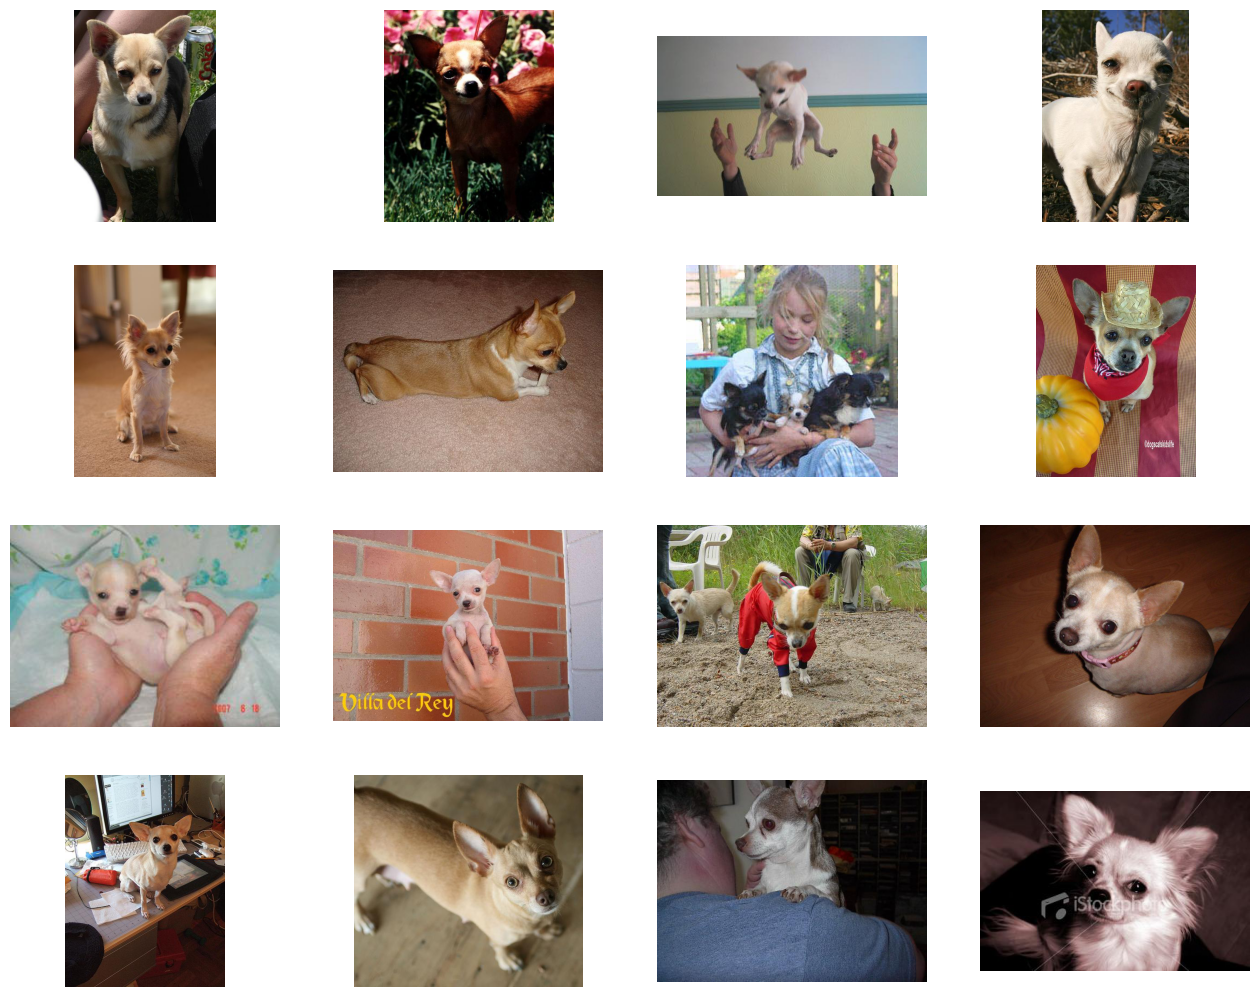

In [6]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

* crop and save pictures

In [ ]:
%%time
# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation

if not os.path.exists('data'):
    os.mkdir('data')

for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))



In [ ]:
for breed in os.listdir('data'):
    for file in os.listdir(r'C:\project\pet_insurance\archive\annotations\Annotation\{}'.format(breed)):
        img = Image.open(r'C:\project\pet_insurance\archive\images\Images\{}\{}.jpg'.format(breed, file))
        tree = ET.parse(r'C:\project\pet_insurance\archive\annotations\Annotation\{}\{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')


* prepare X and y

In [10]:
# [테스트] 100개로 조정 
# # prepare X and y  - 1 품종 당 사진 100개씩
# def paths_and_labels_100():
#     paths = list()
#     labels = list()
#     targets = list()
#     for breed in breed_list:
#         base_name = "./data/{}/".format(breed)
#         img_count = 0  # 각 품종마다 이미지 개수를 카운트
#         for img_name in os.listdir(base_name):
#             if img_count >= 100:  # 각 품종마다 최대 10개만 저장 # 100개 조정 
#                 break
#             paths.append(base_name + img_name)
#             labels.append(breed)
#             targets.append(label_maps[breed])
#             img_count += 1  # 이미지 추가 후 카운트 증가
#     return paths, labels, targets

In [11]:
# paths, labels, targets = paths_and_labels_100()
# print(paths)    
# print(labels)    
# print(targets)
# #각각의 데이터들 갯수 확인
# len(paths), len(labels), len(targets)

In [7]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

In [ ]:
paths, labels, targets = paths_and_labels()
print(paths)
print(labels)
print(targets)
len(paths), len(labels), len(targets)

['./data/n02085620-Chihuahua/n02085620_10074.jpg', './data/n02085620-Chihuahua/n02085620_10131.jpg', './data/n02085620-Chihuahua/n02085620_10621.jpg', './data/n02085620-Chihuahua/n02085620_1073.jpg', './data/n02085620-Chihuahua/n02085620_10976.jpg', './data/n02085620-Chihuahua/n02085620_11140.jpg', './data/n02085620-Chihuahua/n02085620_11238.jpg', './data/n02085620-Chihuahua/n02085620_11258.jpg', './data/n02085620-Chihuahua/n02085620_11337.jpg', './data/n02085620-Chihuahua/n02085620_11477.jpg', './data/n02085620-Chihuahua/n02085620_1152.jpg', './data/n02085620-Chihuahua/n02085620_11696.jpg', './data/n02085620-Chihuahua/n02085620_11818.jpg', './data/n02085620-Chihuahua/n02085620_11948.jpg', './data/n02085620-Chihuahua/n02085620_1205.jpg', './data/n02085620-Chihuahua/n02085620_12101.jpg', './data/n02085620-Chihuahua/n02085620_12334.jpg', './data/n02085620-Chihuahua/n02085620_1235.jpg', './data/n02085620-Chihuahua/n02085620_1271.jpg', './data/n02085620-Chihuahua/n02085620_12718.jpg', './d

(20690, 20690, 20690)

In [ ]:
targets = to_categorical(targets, 121)
print(targets)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


* image generator with augment

In [ ]:
batch_size = 32

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image


* train test split

In [ ]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, targets, test_size=0.15, random_state=1029)

train_gen = ImageGenerator(train_paths,
                           train_targets,     
                           batch_size=32,     
                           shape=(224,224,3),
                           augment=True)      
val_gen = ImageGenerator(val_paths,           
                         val_targets, 
                         batch_size=32, 
                         shape=(224,224,3), 
                         augment=False)      

* keras pretrain densenet121 model

In [ ]:
# 전이학습 : Keras에서 사전 학습된 DenseNet121 모델 사용

inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights=r"C:\project\100.Project\11.1차프로젝트\01.견종판별\dense\DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(121, activation="softmax")(x)

model = Model(inp, outp)


In [ ]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=["acc"])

In [ ]:
checkpoint = ModelCheckpoint(
    'C:/project/100.Project/11.1차프로젝트/01.견종판별/dense/final_dog_breed_model_121_v2.keras',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only=False
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [ ]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=200,
                    validation_data=val_gen,
                    validation_steps=50,
                    epochs=30,
                    callbacks=[checkpoint, reduce_lr, early_stop]
                    )

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - acc: 0.0358 - loss: 4.7762
Epoch 1: val_loss improved from inf to 2.39651, saving model to C:/project/100.Project/11.1차프로젝트/01.견종판별/dense/final_dog_breed_model_121_v2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 591ms/step - acc: 0.0360 - loss: 4.7737 - val_acc: 0.4162 - val_loss: 2.3965 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - acc: 0.2111 - loss: 3.0595
Epoch 2: val_loss improved from 2.39651 to 1.56842, saving model to C:/project/100.Project/11.1차프로젝트/01.견종판별/dense/final_dog_breed_model_121_v2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 114s 573ms/step - acc: 0.2113 - loss: 3.0586 - val_acc: 0.5585 - val_loss: 1.5684 - learning_rate: 0.0010
Epoch 3/30
150/200 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - acc: 0.3179 - loss: 2.4795
Epoch 3: val_loss improved from 1.56842 to 1.31592, saving model to C:/project/100.Project/11.1차프로젝트/01.견종판별/dense/final_dog_breed_model_121_v2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 91s 4

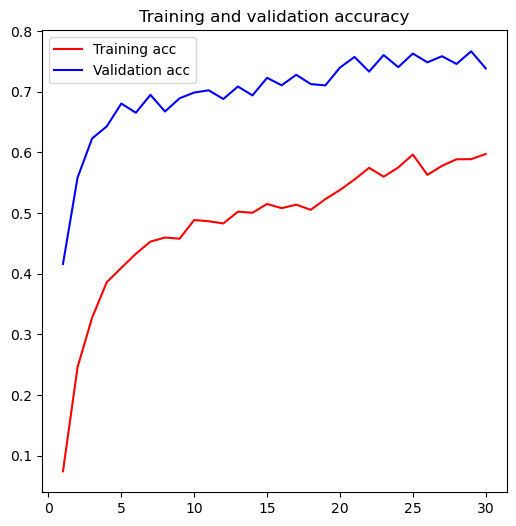

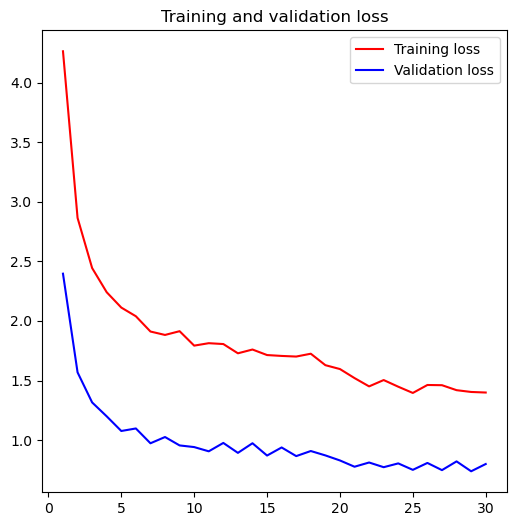

In [20]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

In [21]:
print(max(val_acc))

0.7668750286102295


* predict new images

In [22]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
41.85% 	 malinois
38.59% 	 dhole
11.39% 	 dingo
4.05% 	 kelpie
2.90% 	 German_shepherd


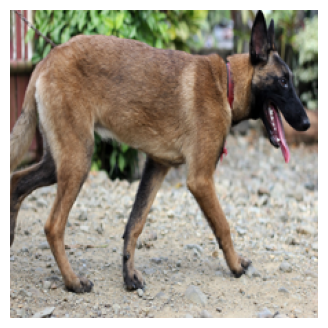

In [23]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
93.73% 	 Pembroke
6.19% 	 Cardigan
0.02% 	 Siberian_husky
0.02% 	 Chihuahua
0.01% 	 Eskimo_dog


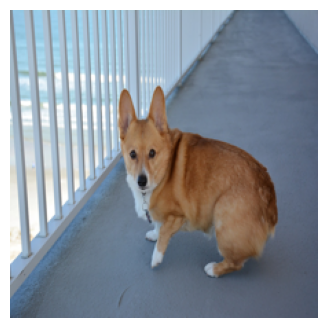

In [24]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
77.91% 	 Chihuahua
20.68% 	 toy_terrier
0.65% 	 miniature_pinscher
0.20% 	 basenji
0.14% 	 papillon


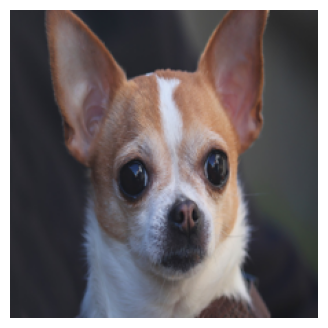

In [25]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
40.68% 	 redbone
32.17% 	 vizsla
17.14% 	 Rhodesian_ridgeback
7.24% 	 Weimaraner
0.48% 	 Great_Dane


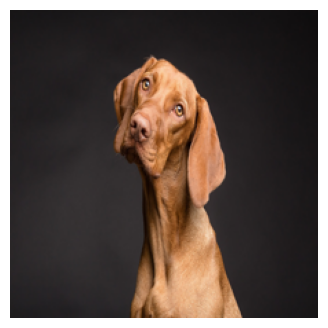

In [26]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
67.11% 	 Labrador_retriever
14.10% 	 golden_retriever
6.59% 	 bull_mastiff
2.76% 	 Chesapeake_Bay_retriever
2.57% 	 vizsla


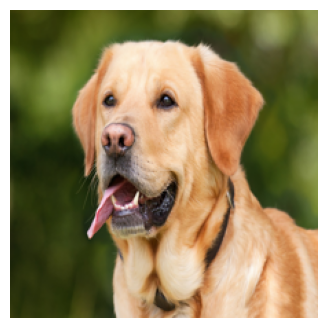

In [27]:
download_and_predict("https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_1280.jpg",
                     "test_5.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
43.06% 	 miniature_poodle
27.87% 	 toy_poodle
17.60% 	 Bichon_frise
10.06% 	 standard_poodle
0.75% 	 Dandie_Dinmont


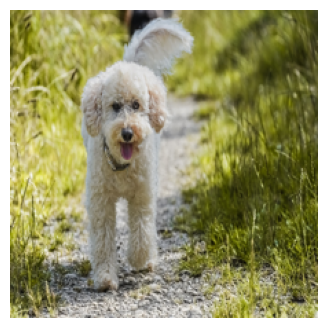

In [28]:
download_and_predict("https://cdn.pixabay.com/photo/2022/07/12/17/12/dog-7317820_1280.jpg", "test_6.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
54.99% 	 Lhasa
31.22% 	 Maltese_dog
13.50% 	 Tzu
0.22% 	 Pekinese
0.05% 	 Tibetan_terrier


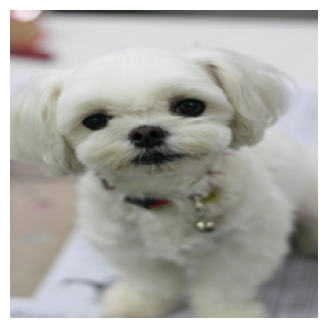

In [29]:
download_and_predict("https://cdn.pixabay.com/photo/2022/04/15/10/26/dog-7134077_1280.jpg", "test_7.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
48.83% 	 miniature_poodle
41.17% 	 toy_poodle
5.10% 	 Bichon_frise
4.83% 	 standard_poodle
0.02% 	 Maltese_dog


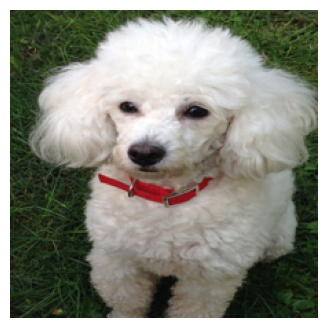

In [30]:

download_and_predict("https://i.pinimg.com/736x/29/c9/a1/29c9a134f91103af59fca8fed7220eaf.jpg", "test_9.jpg")